# Naive Bayes Sentiment Analysis: IMDB Movie Reviews

The goal of this challenge is to create a sentiment analysis classifier using a Naive Bayes model on movie reviews based on text data from reviews on IMDB. The source of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences).

This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

## Imports and Dataset Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, names=['review','positive'])

# Quick Description and Analysis

In [3]:
df.head()

,review,positive
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


Rearrange `df`'s columns so positive indicator is in first position.

In [4]:
cols = ['positive', 'review']
df = df[cols]

### Dataset Description:

This dataset holds relatively clean information from IMDB in the form of text reviews of movies. In addition to that, each review in the set is given an indicator of 0 or 1 for whether the review is positive or not, lukewarm or neutral reviews have been excluded from the dataset.

### Variable Information:

- positive (boolean) - indicator of whether a given review is considered positively reviewed (1) or negatively reviewed (0), I assume this was done manually by the original researcher
- review (text) - the text of a given review in string format

### Quick Analysis

How many positive and negative reviews are in the dataset and what does that distribution look like?

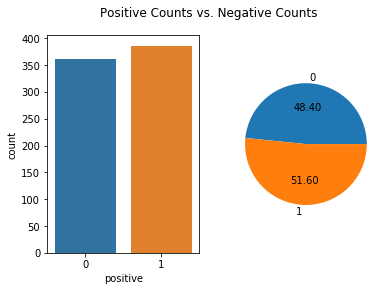

In [5]:
plt.subplot(121)
sns.countplot(x=df.positive)
plt.subplot(122)
df.positive.value_counts(ascending=True).plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.suptitle('Positive Counts vs. Negative Counts')
plt.show()

The amount of positive reviews and negative reviews are relatively even in this dataset.

In order to look into the text data for this dataset, it may be of interest to compare counts of words that appear in the positive reviews against those which appear in negative reviews. This may help give some insight into what words are generally used in positive reviews and negative reviews. This will also help in executing the feature engineering stage.

First, the text data should be simplified so it can be more easily worked with, a very simple method will be used to pare the review data down to one big string of words (all the reviews in a single string). Note: the original review data will be preserved, so other possible features can still be created later.

Separate data into two big strings, one containing words from positive reviews and one containing words from negative reviews.

In [6]:
pos_big_review = ''
for review in df[df.positive == 1].review.values:
    pos_big_review += str(review) + ' '
neg_big_review = ''
for review in df[df.positive == 0].review.values:
    neg_big_review += str(review) + ' '

In [7]:
pos_big_review = pos_big_review.lower()
neg_big_review = neg_big_review.lower()

Filter out all non-words in order to view word counts.

In [8]:
import re
pos_words = re.findall(r"[\w']+", pos_big_review)
neg_words = re.findall(r"[\w']+", neg_big_review)

In [9]:
from collections import Counter
pos_count = Counter(pos_words)
neg_count = Counter(neg_words)

In [10]:
pos_unique_words = list(pos_count.keys())
neg_unique_words = list(neg_count.keys())

Now the words from negative reviews are in one list and the words from positive reviews are in another list. There are also two counter objects (one for negative and one for positive) which acts like a dictionary where the count of a given word can be obtained. Next, what words show up in only negative or positive reviews?

In [11]:
neg_only = []
for word in neg_unique_words:
    if word not in pos_unique_words:
        if neg_count[word] > 2:
            neg_only.append(word)

In [12]:
pos_only = []
for word in pos_unique_words:
    if word not in neg_unique_words:
        if pos_count[word] > 2:
            pos_only.append(word)

This is a good start. There are a list of words that seem to appear in only positive reviews and only negative reviews. Time to begin feature engineering.

# Feature Engineering

Now, boolean indicator variables will be added to `df`, these are indicators that a given review either contains or does not contain a given word, that word will be the name of the variable's column.

In [13]:
keywords = neg_only + pos_only

In [14]:
for key in keywords:
    df[str(key)] = df.review.str.contains(' ' + str(key) + ' ', case=False)

In [15]:
df.shape[1]

143

OK, that is A LOT of columns. It is very likely that some of these indicators correlate highly with one another. Those that do correlate highly should be removed as independence between variables is assumed for Naive Bayes.

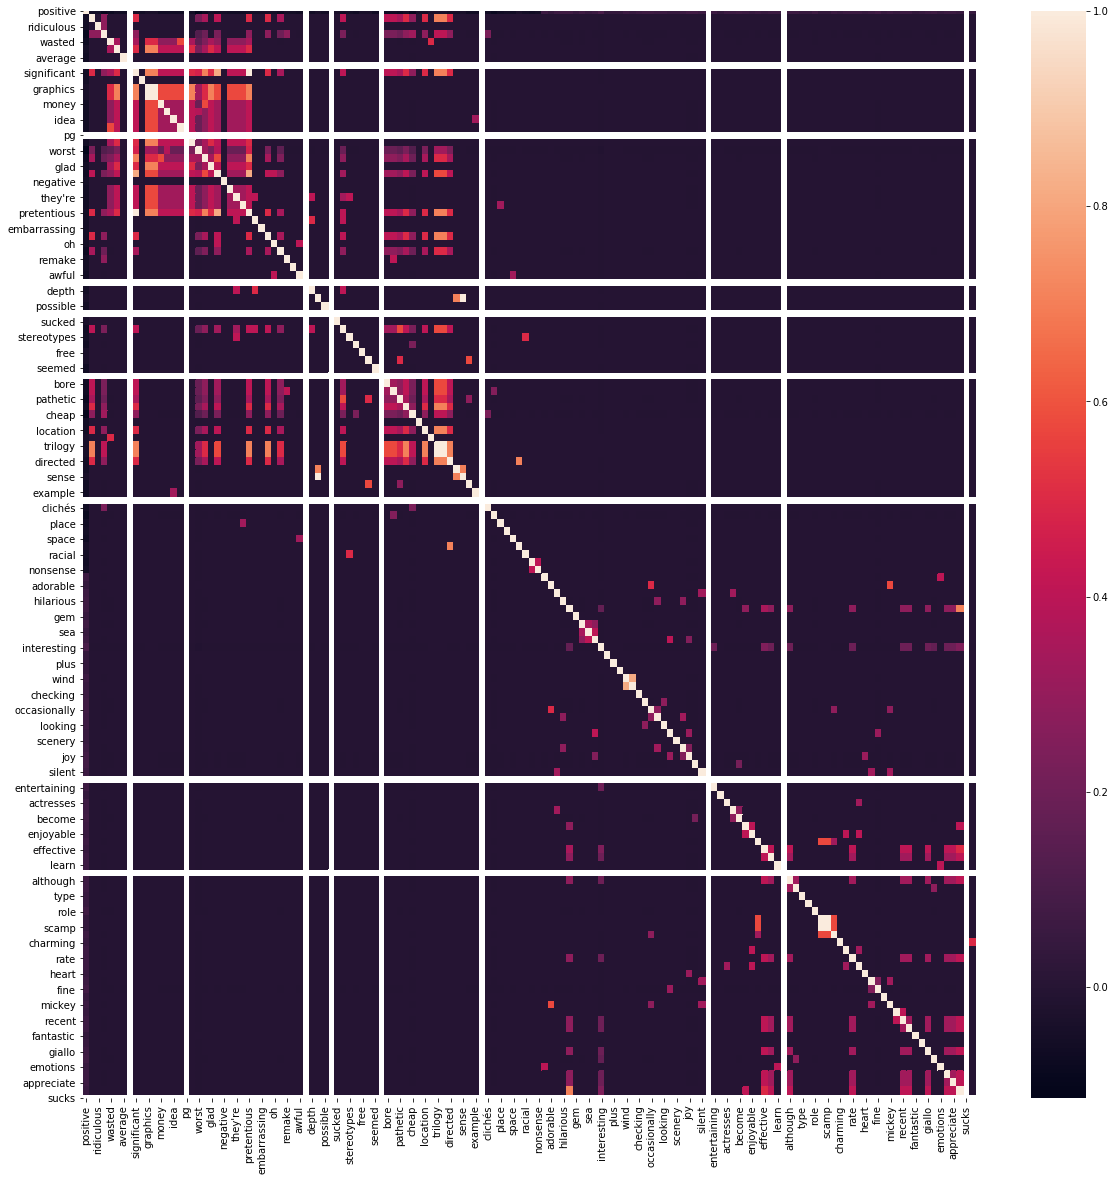

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.show()

Based on the above, there are indeed a number of words that are highly correlated with one another. When that is the case, the variable should be removed.

In [17]:
corr_matrix = df.iloc[:, 2:].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.2)]

In [18]:
df.drop(columns=to_drop, inplace=True)

In [19]:
df.positive = df.positive.astype('bool').copy()

In [20]:
to_drop = []
for col in df.columns.tolist()[2:]:
    if df[col].sum() == 0:
        to_drop.append(col)

In [21]:
df.drop(columns=to_drop, inplace=True)

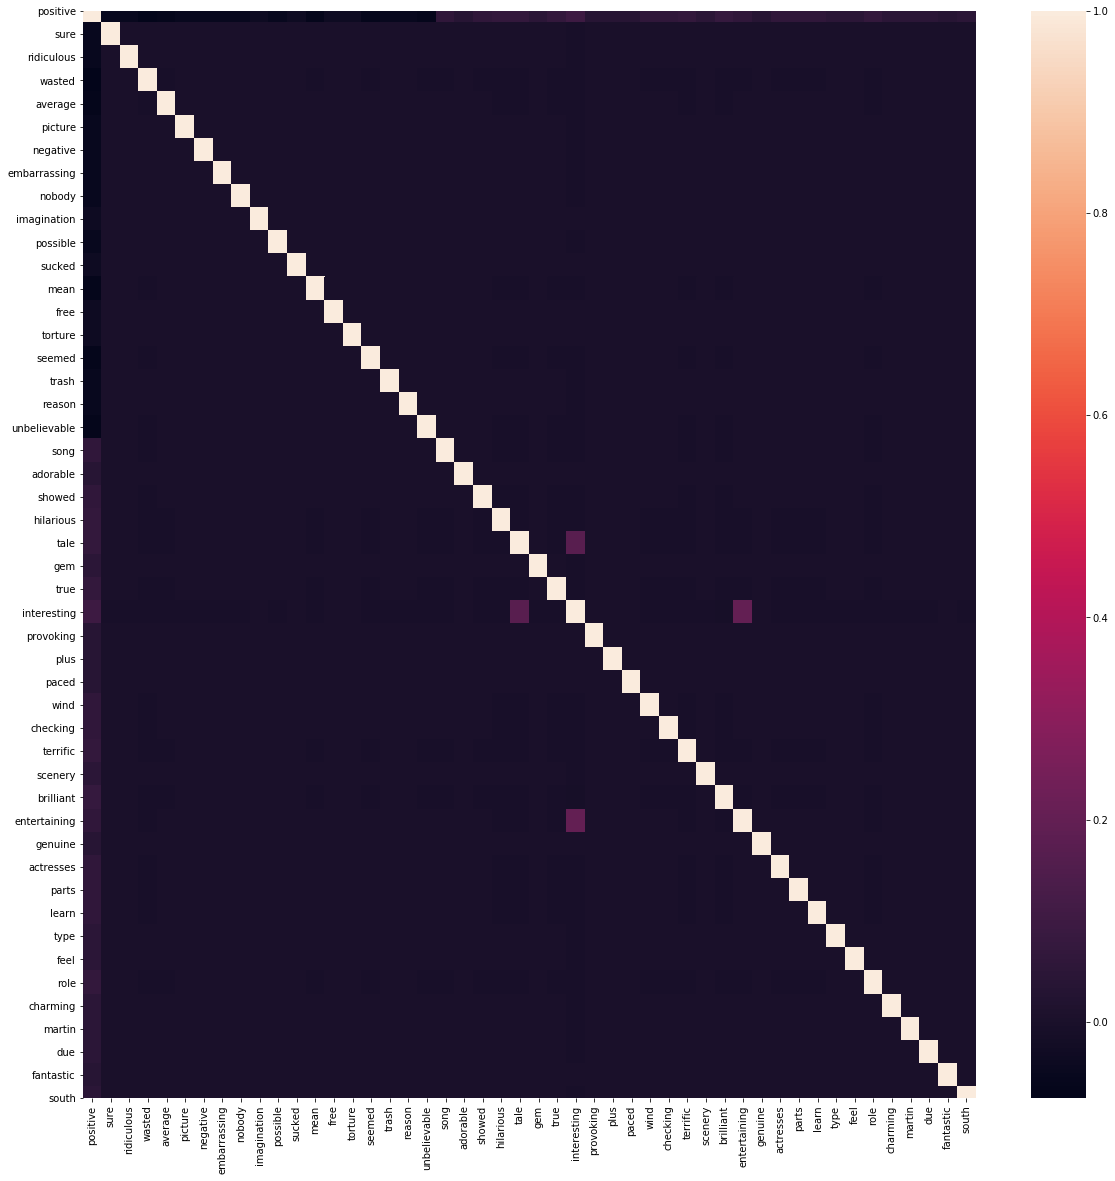

In [22]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.show()

Still a lot of columns, but let's give this a go and see how it works.

# Naive Bayes: Bernoulli

In [23]:
keywords = df.columns.tolist()[2:]

In [24]:
data = df[keywords]
target = df['positive']

In [25]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points out of a total {} points : {}".format(data.shape[0], (target != y_pred).sum()))

Number of mislabeled points out of a total 748 points : 309


So, this model is not very good! Wonder if it works on either of the other datasets.

In [26]:
amazon = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header=None, names=['review', 'positive'])
yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None, names=['review', 'positive'])

In [27]:
for key in keywords:
    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    yelp[str(key)] = yelp.review.str.contains(' ' + str(key) + ' ', case=False)

In [28]:
amazon_data = amazon[keywords]
yelp_data = yelp[keywords]
amazon_target = amazon['positive']
yelp_target = yelp['positive']

In [29]:
amazon_pred = bnb.predict(amazon_data)
yelp_pred = bnb.predict(yelp_data)

In [30]:
print("Amazon - Number of mislabeled points out of a total {} points : {}".format(amazon_data.shape[0], (amazon_target != amazon_pred).sum()))
print("Yelp - Number of mislabeled points out of a total {} points : {}".format(yelp_data.shape[0], (yelp_target != yelp_pred).sum()))

Amazon - Number of mislabeled points out of a total 1000 points : 497
Yelp - Number of mislabeled points out of a total 1000 points : 496


Not too great for any of these, looks like it's right only about 50% of the time.

Definitely need to look into other ways to engineer useful features for sentiment analysis, I'm guessing that other models have the capability of being much more accurate.